In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stumpy
import numpy as np

from sklearn.decomposition import PCA
import sklearn.cluster as cluster

from matplotlib.pyplot import figure

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat
from pyspark.sql import functions as F

## Feature Engineering

### In this code block we will add features to prepare for the upcoming data analysis

In [2]:
original = pd.read_table("data/tracklets_0114.txt", sep='\t')

df = original #Feature engineering for PCA
dk = original #Feature engineering for K means clustering
dl = original #Feature engineering for time-series analysis

# Here we will find the distance and duration features
df['distance'] = abs(df['end_sensor'] - df['begin_sensor'])
df['duration'] = ((df['end_time'] - df['begin_time']) / 1000).astype(int)

# Here we convert the time into data time format
dl['begin_time'] = pd.to_datetime(dl['begin_time'], unit='ms')
dl['end_time'] = pd.to_datetime(dl['end_time'], unit='ms')

# Here we will find the specific hour that the activation occcured
dk['hour'] = dl['begin_time'].dt.hour
dk = dk.head(50000) #we will only collect the first 1000 data points
#just testing this out

## PCA

### In the following code blocks we will perform Principal Component Analysis in order to determine the most significant components of the data

In [7]:
#picture of the office will be inserted here

In [8]:
'''
This function will take the sensor id as input, check under what range 
it will be, and return a corresponding output
'''

def targetting(sensors):
    if(256 < sensors < 290):
        return 1
    elif (454 < sensors < 502):
        return 2
    elif(395 < sensors < 444):
        return 3
    else: 
        return 0

In [9]:
'''
In his code block we will call the targetting function and save the values
into the column 'area'. Then we will drop all rows that have the value 0 in
the area column
'''

df['area'] = df['begin_sensor'].apply(targetting)

data_with_index = df.set_index('area')
data_with_index = data_with_index.drop(0)
data_with_index = data_with_index.reset_index()

In [10]:
'''
Now we will create two new dataframe called x and y, which will be 
the co ordinates for our pca graph.
'''

y = data_with_index['begin_sensor'].apply(targetting) 

#this drops the un needed columns for axis x
data_with_index.drop('begin_time', inplace=True, axis=1)
data_with_index.drop('end_time', inplace=True, axis=1)
data_with_index.drop('area', inplace=True, axis=1)

x = data_with_index
pca = PCA(n_components=2)
x_transform = pca.fit_transform(x)
x_transform

array([[112.65044516,   2.85556608],
       [130.28525617,   2.38385568],
       [121.78884859,   2.01489528],
       ...,
       [ 95.48118102,  -6.80108194],
       [120.54202584,  34.86847049],
       [121.48051051,  14.69574496]])

In [11]:
'''
In this cell we initiate the colors and labels for our plot
'''

colors = ['#ffffff', '#bc5090', '#ffa600', '#219a26']
lw=2

labelled = np.full((4), np.string_)

labelled[0] = 'unknown'
labelled[1] = '8th floor - East (0)'
labelled[2] = '7th floor - North'
labelled[3] = '7th floor - South (2)'

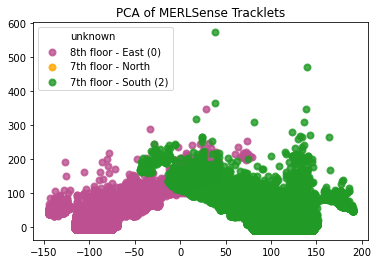

In [12]:
'''
In this cell we will plot the PCA to our results
'''

plt.figure()

for color, i, target_name in zip(colors, [0, 1, 2, 3], labelled):
    plt.scatter(x_transform[y == i, 0], x_transform[y == i, 1], color=color, alpha=.8, lw=lw,
                label=labelled[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MERLSense Tracklets');

# K-means clustering

In [3]:
dk

,begin_sensor,end_sensor,begin_time,end_time,distance,duration,hour
1,420,416,2006-03-22 04:00:24.919,2006-03-22 04:00:39.867,4,14,4
2,434,427,2006-03-22 04:04:17.723,2006-03-22 04:04:25.970,7,8,4
3,428,421,2006-03-22 04:06:50.882,2006-03-22 04:06:58.410,7,7,4
4,420,428,2006-03-22 04:08:39.498,2006-03-22 04:09:15.841,8,36,4
5,423,421,2006-03-22 04:09:17.575,2006-03-22 04:09:21.250,2,3,4
...,...,...,...,...,...,...,...
49998,327,327,2006-03-24 21:03:28.384,2006-03-24 21:03:29.404,0,1,21
49999,347,347,2006-03-24 21:03:28.416,2006-03-24 21:03:29.442,0,1,21
50000,350,350,2006-03-24 21:03:28.904,2006-03-24 21:03:29.935,0,1,21
50001,326,326,2006-03-24 21:03:30.372,2006-03-24 21:03:31.389,0,1,21


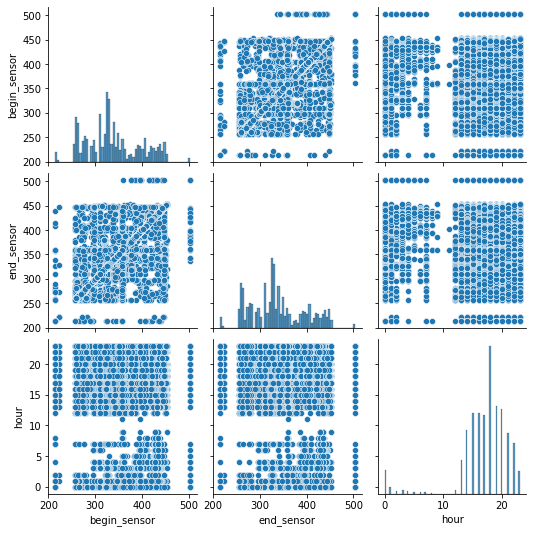

In [4]:
sns.pairplot(dk[['begin_sensor', 'end_sensor', 'hour']])

/var/folders/5z/rs5_z6w113b3qtl8nw6qrdh00000gn/T/ipykernel_97057/333161314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dk['Clusters'] = kmeans.labels_


<AxesSubplot:xlabel='hour', ylabel='begin_sensor'>

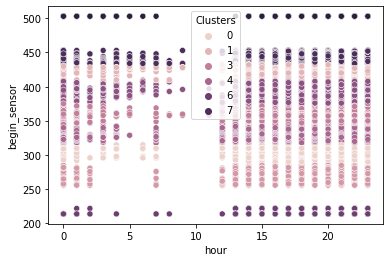

In [5]:

kmeans = cluster.KMeans( n_clusters = 9, init="k-means++")
kmeans = kmeans.fit(dk[['hour','begin_sensor']])

dk['Clusters'] = kmeans.labels_

sns.scatterplot(x="hour", y="begin_sensor", hue="Clusters", data=dk)